In [1]:
import os
import csv
import math
import pandas
import subprocess
import numpy as np
import pysindy as ps
from numpy import diff
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import FormatStrFormatter

##############################################
# Only for now:
import warnings
warnings.filterwarnings('ignore')
##############################################

pandas.set_option("display.precision", 2)

feature_names = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'ux', 'uy', 'uz']
target_names = ['dx/dt', 'dy/dt', 'dz/dt', 'dvx/dt', 'dvy/dt', 'dvz/dt']

In [2]:
# run matlab from python via cmd
MatScriptAbsDir = "C:\\Users\\vvh19\\OneDrive\\Documents\\GitHub\\SatRelMDPC\\src\\matlab\\RelOrbSim\\MAIN.m"
RunMatlabScript_Flag = 0;

if RunMatlabScript_Flag == 1:
    C1 = 'echo Executing Shell Script! && echo: && echo Matlab Output: && echo: && '
    C2 = 'matlab -noFigureWindows -nosplash -nodesktop -batch "run('
    C3 = "'" + MatScriptAbsDir + "'"
    C4 = '); exit;" && echo: && echo Windows Shell Closing! && exit'
    command = C1 + C2 + C3 + C4

    print("Given Command:")
    print(command)
    print("")

    out = subprocess.run(command, shell=True,
    capture_output=True, text=True)
    print(out.stdout)
    

In [3]:
# Import from CSV
CSV_dir = "C:/Users/vvh19/OneDrive/Documents/GitHub/SatRelMDPC/src/matlab/RelOrbSim/Export/"
DataInSI_flag = 1

with open(CSV_dir + 'times.csv', newline='') as csvfile:  
    times = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'a_f_RTH.csv', newline='') as csvfile:  
    a_f_RTH = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'rho.csv', newline='') as csvfile:  
    rho = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'rho_dot.csv', newline='') as csvfile:  
    rho_dot = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'rho_dotdot.csv', newline='') as csvfile:  
    rho_dotdot = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'kep_T.csv', newline='') as csvfile:  
    kep_T = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'kep_C.csv', newline='') as csvfile:  
    kep_C = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'params_T.csv', newline='') as csvfile:  
    params_T = np.array(list(csv.reader(csvfile))).astype(float)
with open(CSV_dir + 'params_C.csv', newline='') as csvfile:  
    params_C = np.array(list(csv.reader(csvfile))).astype(float)

MU = 3.98600433e+5 # From DE405

# Convert to S.I Units
if DataInSI_flag == 1:
    a_f_RTH = a_f_RTH*1e3
    rho = rho*1e3
    rho_dot = rho_dot*1e3
    rho_dotdot = rho_dotdot*1e3
    kep_T[:,0] = kep_T[:,0]*1e3
    kep_C[:,0] = kep_C[:,0]*1e3
    MU = 3.98600433e+5 * 1e9 # From DE405
    

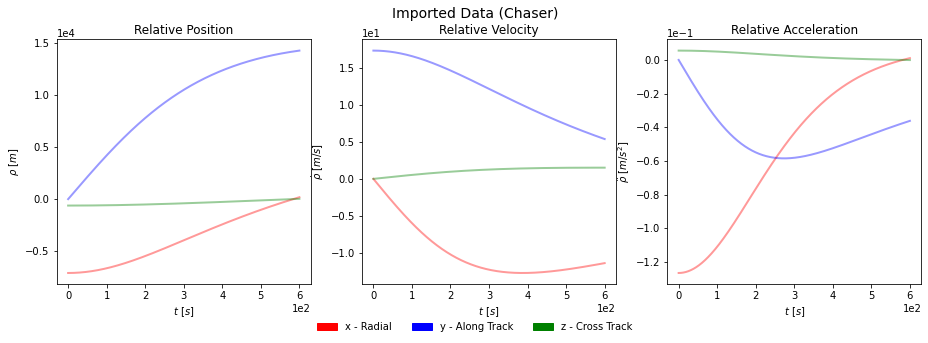

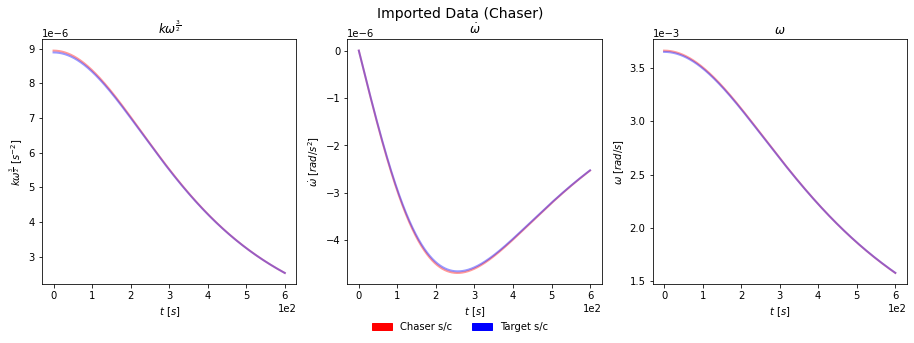

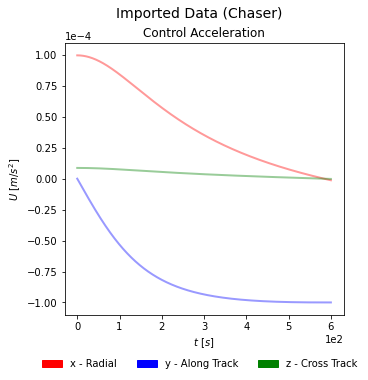

In [4]:
# Plot Imported Data
plot_kws = dict(linewidth=2)
red_patch = mpatches.Patch(color='red')
blue_patch = mpatches.Patch(color='blue')
green_patch = mpatches.Patch(color='green')

# figure 1: rho, rho_dot, rho_dotdot, a_f_RTH
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5, 4.5))
fig.suptitle('Imported Data (Chaser)', fontsize=14)
fig.legend(handles=[red_patch, blue_patch, green_patch],\
           labels=('x - Radial','y - Along Track','z - Cross Track'),\
           loc='lower center', frameon=False, ncol=3, bbox_to_anchor=(0.5, -0.05))

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[0].plot(times, rho[:, 0], "r", alpha=0.4, **plot_kws)
axs[0].plot(times, rho[:, 1], "b", alpha=0.4, **plot_kws)
axs[0].plot(times, rho[:, 2], "g", alpha=0.4, **plot_kws)
axs[0].set_title('Relative Position')
if DataInSI_flag == 1:
    axs[0].set(xlabel="$t~[s]$", ylabel=r"$\rho~[m]$")
else:
    axs[0].set(xlabel="$t~[s]$", ylabel=r"$\rho~[km]$")
# axes[0].grid(True)

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[1].plot(times, rho_dot[:, 0], "r", alpha=0.4, **plot_kws)
axs[1].plot(times, rho_dot[:, 1], "b", alpha=0.4, **plot_kws)
axs[1].plot(times, rho_dot[:, 2], "g", alpha=0.4, **plot_kws)
axs[1].set_title('Relative Velocity')
if DataInSI_flag == 1:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$\dot{\rho}~[m/s]$")
else:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$\dot{\rho}~[m/s]$")

axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[2].plot(times, rho_dotdot[:, 0], "r", alpha=0.4, **plot_kws)
axs[2].plot(times, rho_dotdot[:, 1], "b", alpha=0.4, **plot_kws)
axs[2].plot(times, rho_dotdot[:, 2], "g", alpha=0.4, **plot_kws)
axs[2].set_title('Relative Acceleration')
if DataInSI_flag == 1:
    axs[2].set(xlabel="$t~[s]$", ylabel=r"$\ddot{\rho}~[m/s^2]$")
else:
    axs[2].set(xlabel="$t~[s]$", ylabel=r"$\ddot{\rho}~[km/s^2]$")

# figure 2: params_T, params_C
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5, 4.5))
fig.suptitle('Imported Data (Chaser)', fontsize=14)
fig.legend(handles=[red_patch, blue_patch],\
           labels=('Chaser s/c','Target s/c'),\
           loc='lower center', frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.05))

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[0].plot(times, params_C[:, 0], "r", alpha=0.4, **plot_kws)
axs[0].plot(times, params_T[:, 0], "b", alpha=0.4, **plot_kws)
axs[0].set_title(r"$k\omega^\frac{3}{2}$")
axs[0].set(xlabel="$t~[s]$", ylabel=r"$k\omega^\frac{3}{2}~[s^{-2}]$")
# axes[0].grid(True)

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[1].plot(times, params_C[:, 1], "r", alpha=0.4, **plot_kws)
axs[1].plot(times, params_T[:, 1], "b", alpha=0.4, **plot_kws)
axs[1].set_title(r"$\dot{\omega}$")
axs[1].set(xlabel="$t~[s]$", ylabel=r"$\dot{\omega}~[rad/s^2]$")

axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[2].plot(times, params_C[:, 2], "r", alpha=0.4, **plot_kws)
axs[2].plot(times, params_T[:, 2], "b", alpha=0.4, **plot_kws)
axs[2].set_title(r"$\omega$")
axs[2].set(xlabel="$t~[s]$", ylabel=r"$\omega~[rad/s]$")

# figure 3: Control Acceleration
fig = plt.figure(figsize=(5, 5))
fig.legend(handles=[red_patch, blue_patch, green_patch],\
           labels=('x - Radial','y - Along Track','z - Cross Track'),\
           loc='lower center', frameon=False, ncol=3, bbox_to_anchor=(0.5, -0.05))
fig.suptitle("Imported Data (Chaser)", fontsize=14)
ax = plt.axes()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
ax.plot(times, a_f_RTH[:, 0], "r", alpha=0.4, **plot_kws)
ax.plot(times, a_f_RTH[:, 1], "b", alpha=0.4, **plot_kws)
ax.plot(times, a_f_RTH[:, 2], "g", alpha=0.4, **plot_kws)
ax.set_title('Control Acceleration')
if DataInSI_flag == 1:
    ax.set(xlabel="$t~[s]$", ylabel="$U~[m/s^2]$")
else:
    ax.set(xlabel="$t~[s]$", ylabel="$U~[km/s^2]$")

In [5]:
# Estimate Params from State Measurements
rho_dotdot_homogenous = rho_dotdot - a_f_RTH

######### DO NOT USE CHaser w, dw, kw32 etc for estimation ############
######## According to Y&A it is target's parameters in SysA ###########
######## Not Yet changed, to be done!

######## But also ask, how chaser will know the target parameters IRL? ########

# Experimental Assumption --> "h" is known
est_kw32 = -1*np.divide(rho_dotdot_homogenous[:,2], rho[:,2])
P_Chaser_est = np.multiply( kep_C[:,0], ( 1 - np.multiply(kep_C[:,1], kep_C[:,1]) ) )
H_Chaser_est = np.sqrt(MU*P_Chaser_est)
W_est = np.divide(est_kw32, (MU / H_Chaser_est**(3/2)))**(2/3)
R_est = np.sqrt(np.divide(H_Chaser_est, W_est))

Times = times.reshape(-1)
DT = Times[1] - Times[0]
R_dot_est = np.gradient(R_est, Times)

W_dot_est = (-2/MU)*np.multiply(H_Chaser_est, est_kw32)
W_dot_est = np.gradient(W_est, Times)


[Text(0.5, 0, '$t~[s]$'), Text(0, 0.5, '$\\ddot{\\omega}$')]

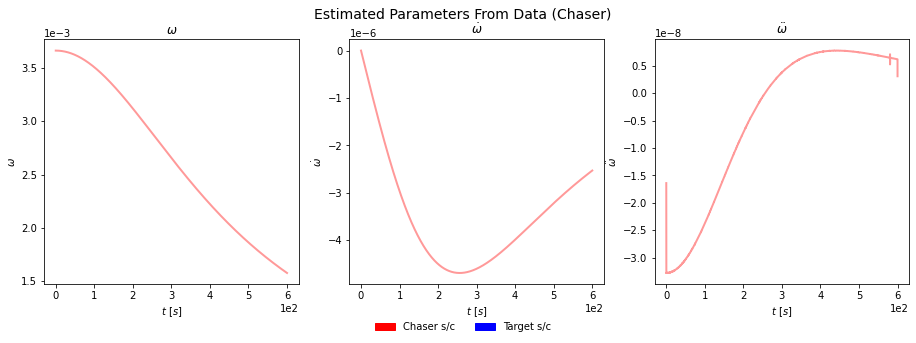

In [6]:
# Plot results:
# figure 1: est_kw32, est_H, est_w
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5, 4.5))
fig.suptitle('Estimated Parameters From Data (Chaser)', fontsize=14)
fig.legend(handles=[red_patch, blue_patch],\
           labels=('Chaser s/c','Target s/c'),\
           loc='lower center', frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.05))

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[0].plot(times, W_est, "r", alpha=0.4, **plot_kws)
axs[0].set_title(r"$\omega$")
axs[0].set(xlabel="$t~[s]$", ylabel=r"$\omega$")

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[1].plot(times, W_dot_est, "r", alpha=0.4, **plot_kws)
axs[1].set_title(r"$\dot{\omega}$")
axs[1].set(xlabel="$t~[s]$", ylabel=r"$\dot{\omega}$")

W_dot_dot_est = np.gradient(W_dot_est, Times)
axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[2].plot(times, W_dot_dot_est, "r", alpha=0.4, **plot_kws)
axs[2].set_title(r"$\ddot{\omega}$")
axs[2].set(xlabel="$t~[s]$", ylabel=r"$\ddot{\omega}$")

(5.436784205222003e-06, 0.0026245113582372844, 0.001532563489388809)


[Text(0.5, 0, '$t~[s]$'), Text(0, 0.5, '$\\omega~[rad/s]$')]

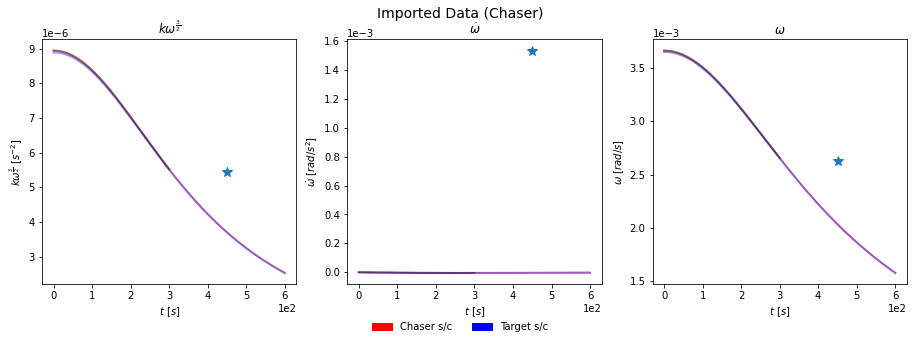

In [7]:
def paramforecast(param, times, DeltaT):
    D_param = np.gradient(param, times)
    DD_param = np.gradient(D_param, times)
    DDD_param = np.gradient(DD_param, times)
    
    E_param = np.mean(param)
    E_D_param = np.mean(D_param)
    E_DD_param = np.mean(DD_param)
    E_DDD_param = np.mean(DDD_param)
    
    E_param_next = E_param + E_D_param*DeltaT + (E_DD_param/2)*DeltaT**2 + (E_DDD_param/6)*DeltaT**3
    
    return E_param_next

L_times = len(Times)
L_pred = int(np.floor(L_times/2))
DelT = 300

est_kw32_Next = paramforecast(est_kw32[0:L_pred], Times[0:L_pred], DelT)
W_est_Next = paramforecast(W_est[0:L_pred], Times[0:L_pred], DelT)
W_dot_est_Next = paramforecast(W_dot_est[0:L_pred], Times[0:L_pred], DelT)

print((est_kw32_Next, W_est_Next, W_dot_est_Next))

# figure 2: params_T, params_C
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5, 4.5))
fig.suptitle('Imported Data (Chaser)', fontsize=14)
fig.legend(handles=[red_patch, blue_patch],\
           labels=('Chaser s/c','Target s/c'),\
           loc='lower center', frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.05))

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[0].plot(times, params_C[:, 0], "r", alpha=0.4, **plot_kws)
axs[0].plot(times, params_T[:, 0], "b", alpha=0.4, **plot_kws)
axs[0].plot(Times[0:L_pred], est_kw32[0:L_pred], "k", alpha=0.4, **plot_kws)
axs[0].plot((Times[L_pred] + DelT), est_kw32_Next, marker="*", markersize=10)
axs[0].set_title(r"$k\omega^\frac{3}{2}$")
axs[0].set(xlabel="$t~[s]$", ylabel=r"$k\omega^\frac{3}{2}~[s^{-2}]$")
# axes[0].grid(True)

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[1].plot(times, params_C[:, 1], "r", alpha=0.4, **plot_kws)
axs[1].plot(times, params_T[:, 1], "b", alpha=0.4, **plot_kws)
axs[1].plot(Times[0:L_pred], W_dot_est[0:L_pred], "k", alpha=0.4, **plot_kws)
axs[1].plot((Times[L_pred] + DelT), W_dot_est_Next, marker="*", markersize=10)
axs[1].set_title(r"$\dot{\omega}$")
axs[1].set(xlabel="$t~[s]$", ylabel=r"$\dot{\omega}~[rad/s^2]$")

axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[2].plot(times, params_C[:, 2], "r", alpha=0.4, **plot_kws)
axs[2].plot(times, params_T[:, 2], "b", alpha=0.4, **plot_kws)
axs[2].plot(Times[0:L_pred], W_est[0:L_pred], "k", alpha=0.4, **plot_kws)
axs[2].plot((Times[L_pred] + DelT), W_est_Next, marker="*", markersize=10)
axs[2].set_title(r"$\omega$")
axs[2].set(xlabel="$t~[s]$", ylabel=r"$\omega~[rad/s]$")

[Text(0.5, 0, '$t~[s]$'), Text(0, 0.5, '$\\dot{\\omega}~[rad/s^2]$')]

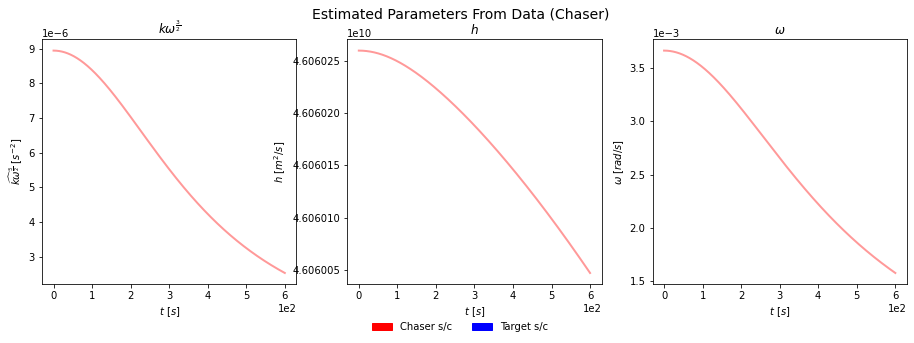

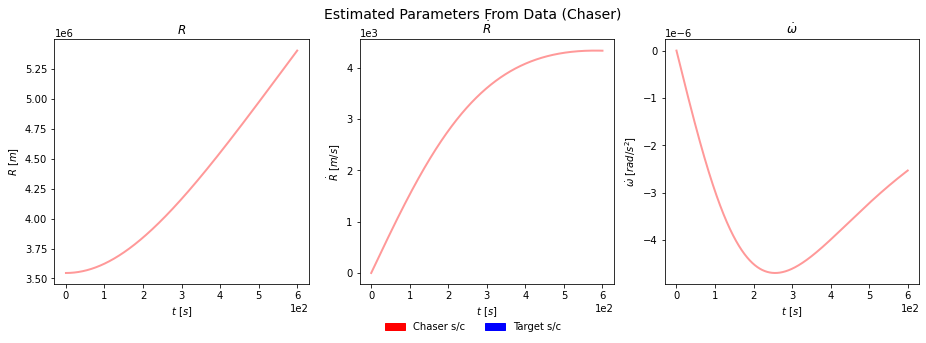

In [8]:
# Plot results:
# figure 1: est_kw32, est_H, est_w
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5, 4.5))
fig.suptitle('Estimated Parameters From Data (Chaser)', fontsize=14)
fig.legend(handles=[red_patch, blue_patch],\
           labels=('Chaser s/c','Target s/c'),\
           loc='lower center', frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.05))

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[0].plot(times, est_kw32, "r", alpha=0.4, **plot_kws)
axs[0].set_title(r"$k\omega^\frac{3}{2}$")
axs[0].set(xlabel="$t~[s]$", ylabel=r"$\widehat{k\omega}^\frac{3}{2}~[s^{-2}]$")
# axes[0].grid(True)

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[1].plot(times, H_Chaser_est, "r", alpha=0.4, **plot_kws)
axs[1].set_title(r"$h$")
if DataInSI_flag == 1:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$h~[m^2/s]$")
else:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$h~[km^2/s]$")

axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[2].plot(times, W_est, "r", alpha=0.4, **plot_kws)
axs[2].set_title(r"$\omega$")
axs[2].set(xlabel="$t~[s]$", ylabel=r"$\omega~[rad/s]$")


# figure 2: est_r, est_r_dot, est_w_dot
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5, 4.5))
fig.suptitle('Estimated Parameters From Data (Chaser)', fontsize=14)
fig.legend(handles=[red_patch, blue_patch],\
           labels=('Chaser s/c','Target s/c'),\
           loc='lower center', frameon=False, ncol=2, bbox_to_anchor=(0.5, -0.05))

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[0].plot(times, R_est, "r", alpha=0.4, **plot_kws)
axs[0].set_title(r"$R$")
if DataInSI_flag == 1:
    axs[0].set(xlabel="$t~[s]$", ylabel=r"$R~[m]$")
else:
    axs[0].set(xlabel="$t~[s]$", ylabel=r"$R~[km]$")

# axes[0].grid(True)

axs[1].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[1].plot(times, R_dot_est, "r", alpha=0.4, **plot_kws)
axs[1].set_title(r"$\dot{R}$")
if DataInSI_flag == 1:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$\dot{R}~[m/s]$")
else:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$\dot{R}~[km/s]$")

axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[2].plot(times, W_dot_est, "r", alpha=0.4, **plot_kws)
axs[2].set_title(r"$\dot{\omega}$")
axs[2].set(xlabel="$t~[s]$", ylabel=r"$\dot{\omega}~[rad/s^2]$")

In [9]:
est_kw32_mean = np.mean(est_kw32)
est_kw32_median = np.median(est_kw32)

est_W_mean = np.mean(W_est)
est_W_median = np.median(W_est)

est_dW_mean = np.mean(W_dot_est)
est_dW_median = np.median(W_dot_est)

measured_mean_kw32 = est_kw32_median
measured_mean_W = est_W_median
measured_mean_dW = est_dW_median

# Formula
    # ax -> (2*kw3_2 + w^2)*x,          dw*y,                0             0        2*w*vy,     1     0     0
    # ay ->      -dw*x,            (w^2 - kw3_2)*y,          0          -2*w*vx,       0        0     1     0
    # az ->        0                      0              -(kw3_2)*z,       0           0        0     0     1

    
k1 = 2*measured_mean_kw32 + measured_mean_W**2   # (2*kw3_2 + w^2)
k2 = measured_mean_W**2 - measured_mean_kw32     # ((w^2 - kw3_2)
k3 = -measured_mean_kw32                         # -(kw3_2)
k4 = measured_mean_dW                            # (dw)
k5 = 2*measured_mean_W                           # (2*w)

Sys_A = pandas.DataFrame(np.asarray([k1, k2, k3, k4, k5]), index=['2*kw3_2 + w^2', 'w^2 - kw3_2', '-kw3_2', 'dw', '2*w'], columns=[''])
print("Initial Guess Coefficients --> Estimated From Measurements:")
print(Sys_A)
print("")
print("")

initial_guess_trial = np.array([[    0,     0,     0,     1,     0,     0,     0,     0,     0],
                                [    0,     0,     0,     0,     1,     0,     0,     0,     0],
                                [    0,     0,     0,     0,     0,     1,     0,     0,     0],
                                [   k1,    k4,     0,     0,     0,    k5,     1,     0,     0],
                                [  -k4,    k2,     0,     0,   -k5,     0,     0,     1,     0],
                                [    0,     0,    k3,     0,     0,     0,     0,     0,     1]])

Sys_A = pandas.DataFrame(initial_guess_trial, columns=feature_names, index=target_names)
print("Initial Guess System LTI Matrix --> Estimated From Measurements:")
print("")
print(Sys_A)
print("")

Initial Guess Coefficients --> Estimated From Measurements:
                       
2*kw3_2 + w^2  1.81e-05
w^2 - kw3_2    1.53e-06
-kw3_2        -5.52e-06
dw            -3.71e-06
2*w            5.31e-03


Initial Guess System LTI Matrix --> Estimated From Measurements:

               x         y         z   vx        vy        vz   ux   uy   uz
dx/dt   0.00e+00  0.00e+00  0.00e+00  1.0  0.00e+00  0.00e+00  0.0  0.0  0.0
dy/dt   0.00e+00  0.00e+00  0.00e+00  0.0  1.00e+00  0.00e+00  0.0  0.0  0.0
dz/dt   0.00e+00  0.00e+00  0.00e+00  0.0  0.00e+00  1.00e+00  0.0  0.0  0.0
dvx/dt  1.81e-05 -3.71e-06  0.00e+00  0.0  0.00e+00  5.31e-03  1.0  0.0  0.0
dvy/dt  3.71e-06  1.53e-06  0.00e+00  0.0 -5.31e-03  0.00e+00  0.0  1.0  0.0
dvz/dt  0.00e+00  0.00e+00 -5.52e-06  0.0  0.00e+00  0.00e+00  0.0  0.0  1.0



In [10]:
# Estimation of System Matrix --> Estimate Params
# Structure the data arrays
X = np.concatenate((rho, rho_dot), axis=1)
X_dot = np.concatenate((rho_dot, rho_dotdot), axis=1)
T = times.reshape(-1) # 0 D Array

# ToDo: Split data into train and test sets
x_train = X
t_train = T
Inputs_train = a_f_RTH
x_dot_precomputed = X_dot
N_ensembles = 50

dt = (t_train[1]-t_train[0])
identity_library = ps.IdentityLibrary()
identity_library.fit(np.concatenate((x_train, Inputs_train), axis=1))

# differentiation_method = ps.FiniteDifference(order=4) # Good
differentiation_method = ps.SmoothedFiniteDifference(smoother_kws={'window_length': 5}, order=6) # Better

n_features = identity_library.n_output_features_

# Set constraints
n_targets = x_train.shape[1]

# constraint_rhs = np.array([1,1,1,1,1,1,0,0,0, -measured_mean_kw32, 2*measured_mean_W])
constraint_rhs = np.array([1,1,1,1,1,1,0,0,0,k5])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((constraint_rhs.size, n_targets * n_features))

# Format:
# constraint_lhs[constraint_number, coefficient_of_which_feature + contribution_to_which_target*n_features] = coefficient_factor
# f:feature, t:target, C:coefficient --> C[f1/t3] = coefficient for contribution of f1 in t3

# constraint_lhs[Constraint_number_in_[constraint_rhs], {f?} + {t?}*n_features] = coefficient_multiplier  # c1

# For vx = ........
constraint_lhs[0, 3+0*n_features] = 1.0 # vx
# For vy = ........
constraint_lhs[1, 4+1*n_features] = 1.0 # vy
# For vz = ........
constraint_lhs[2, 5+2*n_features] = 1.0 # vz
# For ax = ........
constraint_lhs[3, 6+3*n_features] = 1.0 # ux
# For ay = ........
constraint_lhs[4, 7+4*n_features] = 1.0 # uy
# For az = ........
constraint_lhs[5, 8+5*n_features] = 1.0 # uz

# For Combined Constraints
# 1*C(ax/y) + 1*C(ay/x) = 0
constraint_lhs[6, 1+3*n_features] = 1.0 # y
constraint_lhs[6, 0+4*n_features] = 1.0 # x
# 1*C(ax/vy) + 1*C(ay/vx) = 0
constraint_lhs[7, 4+3*n_features] = 1.0 # vy
constraint_lhs[7, 3+4*n_features] = 1.0 # vx
# 1*C(ax/x) + -1*C(ay/y) + 3*C(az/z)= 0
constraint_lhs[8, 0+3*n_features] =  1.0 # x
constraint_lhs[8, 1+4*n_features] = -1.0 # y
constraint_lhs[8, 2+5*n_features] =  3.0 # z

# For 2W Constraint in ax
constraint_lhs[9, 4+3*n_features] = 1.0 # vz

s = math.inf;
f = 1e-2;
# Each row corresponds to a measurement variable and each column to a function 
# from the feature library

# States                  x       y       z       dx      dy      dz     ux     uy     uz
a_thresholds = np.abs(np.array([[s,      s,      s,      0,      s,      s,     s,     s,      s],        # vx
                                [s,      s,      s,      s,      0,      s,     s,     s,      s],        # vy
                                [s,      s,      s,      s,      s,      0,     s,     s,      s],        # vz
                                [k1*f,   k4*f,   s,      s,      k5*f,   s,     0,     s,      s],        # ax
                                [k4*f,   k2*f,   s,      k5*f,   s,      s,     s,     0,      s],        # ay
                                [s,      s,      k3*f,   s,      s,      s,     s,     s,      0]     ])) # az

Sys_A = pandas.DataFrame(a_thresholds, columns=feature_names, index=target_names)
print("Estimated System LTI Matrix Thresholds:")
print("")
print(Sys_A)
print("")

Estimated System LTI Matrix Thresholds:

               x         y         z        vx        vy   vz   ux   uy   uz
dx/dt        inf       inf       inf  0.00e+00       inf  inf  inf  inf  inf
dy/dt        inf       inf       inf       inf  0.00e+00  inf  inf  inf  inf
dz/dt        inf       inf       inf       inf       inf  0.0  inf  inf  inf
dvx/dt  1.81e-07  3.71e-08       inf       inf  5.31e-05  inf  0.0  inf  inf
dvy/dt  3.71e-08  1.53e-08       inf  5.31e-05       inf  inf  inf  0.0  inf
dvz/dt       inf       inf  5.52e-08       inf       inf  inf  inf  inf  0.0



In [11]:
csr3_optimizer = ps.ConstrainedSR3(constraint_rhs=constraint_rhs, 
                                   constraint_lhs=constraint_lhs,
                                   thresholder="weighted_l1",
                                   nu=0.0000000001,
                                   tol=1e-16,
                                   max_iter=100,
                                   normalize_columns=False,
                                   initial_guess=initial_guess_trial,
                                   # trimming_fraction=0.1,
                                   fit_intercept=True,
                                   inequality_constraints = False,
                                   thresholds=a_thresholds,
)

# Fit The Model
model = ps.SINDy(feature_names = feature_names,
                 optimizer = csr3_optimizer,
                 feature_library = identity_library,
                 differentiation_method=differentiation_method,
)
model.fit(x_train, 
          t=dt, 
          u=Inputs_train,
          ensemble=True,
          n_models=N_ensembles,
          # n_candidates_to_drop=1, 
          unbias=True
          # quiet=True
)
# Formula
    # ax -> (2*kw3_2 + w^2)*x,          dw*y,                0             0        2*w*vy,     1     0     0
    # ay ->      -dw*x,            (w^2 - kw3_2)*y,          0          -2*w*vx,       0        0     1     0
    # az ->        0                      0              -(kw3_2)*z,       0           0        0     0     1

Model_Coef_List = model.coef_list
Model_Coefs = model.coefficients()

Sys_A = pandas.DataFrame(Model_Coefs, columns=feature_names, index=target_names)
print("Estimated System LTI Matrix --> Ensemble Bagged (Default Method):")
print("")
print(Sys_A)
print("")

########## WHERE IS W IN ENSEMBLE DEFAULT BAGGED SYSA? ##########
########## NOT YET RESOLVED! TO BE DONE
##### Maybe try giving 2w as a constraint to avoid above issue of 2w ommision?

Estimated System LTI Matrix --> Ensemble Bagged (Default Method):

               x         y         z        vx        vy   vz   ux   uy   uz
dx/dt  -0.00e+00  0.00e+00 -0.00e+00  1.00e+00  0.00e+00  0.0 -0.0 -0.0  0.0
dy/dt  -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00  1.00e+00 -0.0  0.0 -0.0  0.0
dz/dt   0.00e+00 -0.00e+00  0.00e+00  0.00e+00 -0.00e+00  1.0 -0.0  0.0 -0.0
dvx/dt  1.58e-05  1.29e-06 -0.00e+00 -0.00e+00  5.26e-03  0.0  1.0 -0.0 -0.0
dvy/dt -1.29e-06 -9.15e-06  0.00e+00 -5.26e-03 -0.00e+00 -0.0 -0.0  1.0 -0.0
dvz/dt  0.00e+00 -0.00e+00 -8.32e-06  0.00e+00 -0.00e+00 -0.0  0.0  0.0  1.0



Estimated System LTI Matrix --> Ensemble Weighted MSE Bagged:

               x         y         z        vx        vy   vz   ux   uy   uz
dx/dt   0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.00e+00  0.0  0.0  0.0  0.0
dy/dt   0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.00e+00  0.0  0.0  0.0  0.0
dz/dt   0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.0  0.0  0.0  0.0
dvx/dt  1.58e-05  1.30e-06  0.00e+00  0.00e+00  5.26e-03  0.0  1.0  0.0  0.0
dvy/dt -1.30e-06 -9.15e-06  0.00e+00 -5.26e-03  0.00e+00  0.0  0.0  1.0  0.0
dvz/dt  0.00e+00  0.00e+00 -8.32e-06  0.00e+00  0.00e+00  0.0  0.0  0.0  1.0



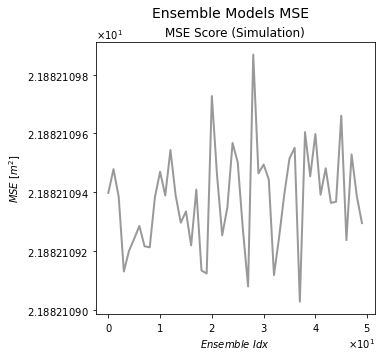

In [12]:
# SysA Bagging from Ensembles Coefficient List

# function to compute the average of the coefficients, weighted by the MSE on the test data.
def weighted_coefficient_average(coef_list, x_test, dt, U, optimizer):
    mse = np.zeros(np.shape(coef_list)[0])
    for i in range(np.shape(coef_list)[0]):
        optimizer.coef_ = np.asarray(coef_list)[i, :, :]
        # For other metrics for scoring: https://scikit-learn.org/stable/modules/model_evaluation.html
        mse[i] = model.score(x_test, t=dt, u=U, metric=mean_squared_error)
    avg = np.average(coef_list, axis=0, weights=mse)
    return avg, mse

e_wavg, e_mse = weighted_coefficient_average(Model_Coef_List, x_train, dt, Inputs_train, csr3_optimizer)

# Bagging Via MSE Weighted Average 
Sys_A_e_wavg = pandas.DataFrame(e_wavg, columns=feature_names, index=target_names) # Better Bagging
print("Estimated System LTI Matrix --> Ensemble Weighted MSE Bagged:")
print("")
print(Sys_A_e_wavg)
print("")

# figure 1: Ensemble Models MSE
fig = plt.figure(figsize=(5, 5))
fig.suptitle("Ensemble Models MSE", fontsize=14)
ax = plt.axes()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False, useMathText=True, useLocale=True)
ax.plot(e_mse, "k", alpha=0.4, **plot_kws)
ax.set_title('MSE Score (Simulation)')
if DataInSI_flag == 1:
    ax.set(xlabel="$Ensemble~Idx$", ylabel="$MSE~[m^2]$")
else:
    ax.set(xlabel="$Ensemble~Idx$", ylabel="$MSE$~[km^2]")
    
########## WHERE IS W IN ENSEMBLE WEIGHTED MSE BAGGED SYSA? ##########
########## NOT YET RESOLVED! TO BE DONE

In [13]:
ensemble_optimizer = csr3_optimizer
ensemble_coefs = np.asarray(model.coef_list)
mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
median_ensemble_coefs = np.median(ensemble_coefs, axis=0)

x0_test_sim = X[0,:]
t_test_sim = T

# Predict the testing trajectory with the mean and median models
ensemble_optimizer.coef_ = mean_ensemble_coefs
x_test_sim_mean = model.simulate(x0_test_sim, t_test_sim, u=Inputs_train)
ensemble_optimizer.coef_ = median_ensemble_coefs
x_test_sim_median = model.simulate(x0_test_sim, t_test_sim, u=Inputs_train)

# Predict the testing trajectory with all the models
x_test_sims = []
for i in range(ensemble_coefs.shape[0]):
    ensemble_optimizer.coef_ = ensemble_coefs[i, :, :]
    x_test_sims.append(model.simulate(x0_test_sim, t_test_sim, u=Inputs_train))

# Compute the 2.5 and 97.5 percentile trajectories
bottom_line = np.percentile(x_test_sims, 2.5, axis=0)
top_line = np.percentile(x_test_sims, 97.5, axis=0)

# Plot trajectory results
fig = plt.figure(figsize=(15.5, 4.5))
fig.suptitle("Ensemble Models (Percentile: [2.5 - 97.5]) Trajectory Simulations", fontsize=14)
ax = plt.axes()
ax.ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False, useMathText=True, useLocale=True)
    
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(times, rho[:, i], 'k', label='True')
    plt.plot(t_test_sim[:-1], x_test_sim_mean[:, i], 'b', label='Mean')
    plt.plot(t_test_sim[:-1], x_test_sim_median[:, i], 'r', label='Median')
    plt.plot(t_test_sim[:-1], bottom_line[:, i], 'g--', alpha=0.6, label='95th percentile')
    plt.plot(t_test_sim[:-1], top_line[:, i], 'g--', alpha=0.6)
    ax = plt.gca()
    ax.fill_between(t_test_sim[:-1], bottom_line[:, i], top_line[:, i], color='g', alpha=0.3)
    if i != 2:
        ax.set_xticklabels([])
    else:
        plt.xlabel("$t~[s]$")
    if DataInSI_flag == 1:
        plt.ylabel("$" + feature_names[i] + " [m]$")
    else:
        plt.ylabel("$" + feature_names[i] + " [km]$")
    if i == 0:
        fig.legend(loc='lower center', frameon=False, ncol=4, bbox_to_anchor=(0.5, -0.05))
        
# Plot 3D trajectory results
%matplotlib qt
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
plt.plot(rho[:, 0], rho[:, 1], rho[:, 2], 'k', label='True')
plt.plot(x_test_sim_mean[:, 0], x_test_sim_mean[:, 1], x_test_sim_mean[:, 2],'b', label='Mean')
plt.plot(x_test_sim_median[:, 0], x_test_sim_median[:, 1], x_test_sim_median[:, 2], 'r', label='Median')
plt.grid(True)
plt.ylabel(feature_names[i], fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.show()


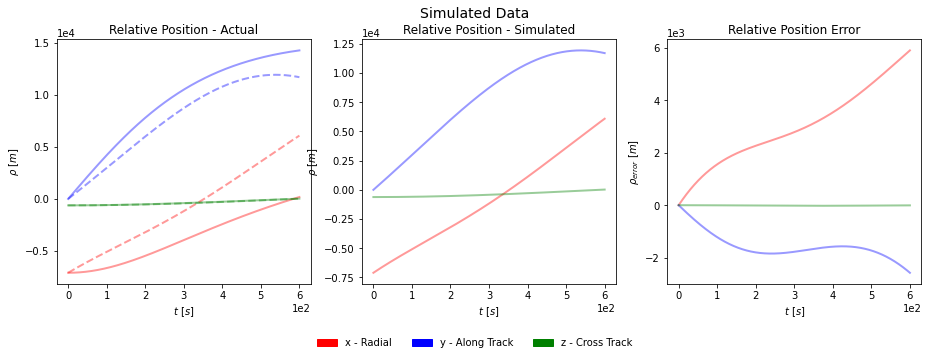

In [14]:
# Simulating Weighted MSE Coefficients:

sim_optimizer = csr3_optimizer
sim_optimizer.coef_ = e_wavg
x0_test_sim = X[0,:]
x_test_sim = model.simulate(x0_test_sim, T, u=Inputs_train)
t_test_sim = T[:-1]

# Error between simulated and imported data and plot
rho_error_sim = x_test_sim - X[:-1,:]

# figure 1: rho_sim, error_rho_sim
%matplotlib inline
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15.5, 4.5))
fig.suptitle('Simulated Data', fontsize=14)
fig.legend(handles=[red_patch, blue_patch, green_patch],\
           labels=('x - Radial','y - Along Track','z - Cross Track'),\
           loc='lower center', frameon=False, ncol=3, bbox_to_anchor=(0.5, -0.1))

axs[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[0].plot(times, rho[:, 0], "r", alpha=0.4, **plot_kws)
axs[0].plot(times, rho[:, 1], "b", alpha=0.4, **plot_kws)
axs[0].plot(times, rho[:, 2], "g", alpha=0.4, **plot_kws)
axs[0].plot(t_test_sim, x_test_sim[:, 0], "r--", alpha=0.4, **plot_kws)
axs[0].plot(t_test_sim, x_test_sim[:, 1], "b--", alpha=0.4, **plot_kws)
axs[0].plot(t_test_sim, x_test_sim[:, 2], "g--", alpha=0.4, **plot_kws)
axs[0].set_title('Relative Position - Actual')
if DataInSI_flag == 1:
    axs[0].set(xlabel="$t~[s]$", ylabel=r"$\rho~[m]$")
else:
    axs[0].set(xlabel="$t~[s]$", ylabel=r"$\rho~[km]$")
    
axs[1].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[1].plot(t_test_sim, x_test_sim[:, 0], "r", alpha=0.4, **plot_kws)
axs[1].plot(t_test_sim, x_test_sim[:, 1], "b", alpha=0.4, **plot_kws)
axs[1].plot(t_test_sim, x_test_sim[:, 2], "g", alpha=0.4, **plot_kws)
axs[1].set_title('Relative Position - Simulated')
if DataInSI_flag == 1:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$\rho~[m]$")
else:
    axs[1].set(xlabel="$t~[s]$", ylabel=r"$\rho~[km]$")

    
axs[2].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useOffset=False)
axs[2].plot(t_test_sim, rho_error_sim[:, 0], "r", alpha=0.4, **plot_kws)
axs[2].plot(t_test_sim, rho_error_sim[:, 1], "b", alpha=0.4, **plot_kws)
axs[2].plot(t_test_sim, rho_error_sim[:, 2], "g", alpha=0.4, **plot_kws)
axs[2].set_title('Relative Position Error')
if DataInSI_flag == 1:
    axs[2].set(xlabel="$t~[s]$", ylabel=r"$\rho_{error}~[m]$")
else:
    axs[2].set(xlabel="$t~[s]$", ylabel=r"$\rho_{error}~[km]$")
